## Strassen algorithm

In the work [Gaussian elimination is not optimal](http://link.springer.com/article/10.1007%2FBF02165411?LI=true) (1969) Strassen found that one can calculate $C$ using 18 additions and only 7 multiplications:
$$
\begin{split}
c_{11} &= f_1 + f_4 - f_5 + f_7, \\
c_{12} &= f_3 + f_5, \\
c_{21} &= f_2 + f_4, \\
c_{22} &= f_1 - f_2 + f_3 + f_6,
\end{split}
$$
where
$$
\begin{split}
f_1 &= (a_{11} + a_{22}) (b_{11} + b_{22}), \\
f_2 &= (a_{21} + a_{22}) b_{11}, \\
f_3 &= a_{11} (b_{12} - b_{22}), \\
f_4 &= a_{22} (b_{21} - b_{11}), \\
f_5 &= (a_{11} + a_{12}) b_{22}, \\
f_6 &= (a_{21} - a_{11}) (b_{11} + b_{12}), \\
f_7 &= (a_{12} - a_{22}) (b_{21} + b_{22}).
\end{split}
$$

Fortunately, these formulas hold even if $a_{ij}$ and $b_{ij}$, $i,j=1,2$ are block matrices.

Thus, Strassen algorithm looks as follows. 
- First of all we <font color='red'>split</font> matrices $A$ and $B$ of sizes $n\times n$, $n=2^d$ <font color='red'> into 4 blocks</font> of size $\frac{n}{2}\times \frac{n}{2}$
- Then we <font color='red'>calculate multiplications</font> in the described formulas <font color='red'>recursively</font>

This leads us again to the **divide and conquer** idea.

## Manual implementation

In [21]:
import numpy as np

def matmul_strassen(a, b):
  if type(a) != np.ndarray and type(b) != np.ndarray:
     return a*b
  
  base_n = len(a)
  if base_n % 2 != 0:
    a = np.pad(a, ((0, 1), (0, 1)), mode='constant', constant_values=0)
    b = np.pad(b, ((0, 1), (0, 1)), mode='constant', constant_values=0)

  n = len(a)

  if n <= 667:
    return (a@b)[:base_n, :base_n]
    #return a@b
  
  #Extract blocks
  a11 = a[:int(n/2),:int(n/2)] if n > 2 else a[0, 0]
  a21 = a[int(n/2):,:int(n/2)] if n > 2 else a[1, 0]
  a12 = a[:int(n/2),int(n/2):] if n > 2 else a[0, 1]
  a22 = a[int(n/2):,int(n/2):] if n > 2 else a[1, 1]
  b11 = b[:int(n/2),:int(n/2)] if n > 2 else b[0, 0]
  b21 = b[int(n/2):,:int(n/2)] if n > 2 else b[1, 0]
  b12 = b[:int(n/2),int(n/2):] if n > 2 else b[0, 1]
  b22 = b[int(n/2):,int(n/2):] if n > 2 else b[1, 1]

  #Compute products
  f1 = matmul_strassen(a11+a22, b11+b22)
  f2 = matmul_strassen(a21+a22, b11)
  f3 = matmul_strassen(a11, b12-b22)
  f4 = matmul_strassen(a22, b21-b11)
  f5 = matmul_strassen(a11+a12, b22)
  f6 = matmul_strassen(a21-a11, b11+b12)
  f7 = matmul_strassen(a12-a22, b21+b22)

  #Compute matrix
  sums = [
     f1 + f4 - f5 + f7,
     f3 + f5,
     f2 + f4,
     f1 - f2 + f3 + f6
  ]
  inds = [
     (0, 0),
     (0, 1),
     (1, 0),
     (1, 1)
  ]
  result = np.ndarray((n, n))
  for i in range(4):
    if n == 2:
      result[*inds[i]] = sums[i]
    else:
      result[
        int(n/2*inds[i][0]):int(n/2*(inds[i][0]+1)), 
        int(n/2*inds[i][1]):int(n/2*(inds[i][1]+1))
      ] = sums[i]
  
  result = result[:base_n, :base_n]
  return result

a = np.array([
    [1, 2, 3, 4, 5],
    [1, 2, 3, 4, 5],
    [1, 2, 3, 4, 5],
    [1, 2, 3, 4, 5],
    [1, 2, 3, 4, 5]
])

print("Naive:\n", a@a)
c = matmul_strassen(a, a)
print("Strassen:\n", c)


Naive:
 [[15 30 45 60 75]
 [15 30 45 60 75]
 [15 30 45 60 75]
 [15 30 45 60 75]
 [15 30 45 60 75]]
Strassen:
 [[15 30 45 60 75]
 [15 30 45 60 75]
 [15 30 45 60 75]
 [15 30 45 60 75]
 [15 30 45 60 75]]


## Algorithm visualization

Strassen algorighm can be rewritten in this way (may be it will be easier to memorize):

(If no image, see the source: https://ru.wikipedia.org/wiki/%D0%90%D0%BB%D0%B3%D0%BE%D1%80%D0%B8%D1%82%D0%BC_%D0%A8%D1%82%D1%80%D0%B0%D1%81%D1%81%D0%B5%D0%BD%D0%B0)
<img width=100% src="./strassen.png">

## Comparing to naive multiplication

Now let's check how efficient Strassen's algorithm is compared to the naive matrix multiplication algorithm.
As you remember from the lecture, Strassen algorithm becomes faster when

\begin{align*}
2n^3 &> 7 n^{\log_2 7}, \\
n &> 667,
\end{align*}

100%|██████████| 10/10 [00:12<00:00,  1.21s/it]


Text(0, 0.5, 'Time')

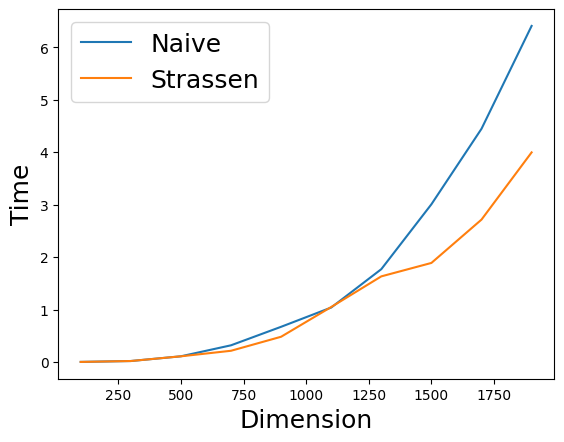

In [ ]:
import time
from tqdm import tqdm
import matplotlib.pyplot as plt
%matplotlib inline

def matmul_naive(a, b):
    n = len(a)
    result = np.ndarray((n, n))
    for i in range(n):
        for j in range(n):
            result[i][j] = sum([a[i][k]*b[k][j] for k in range(n)])
    return result

sizes = list(range(100, 2000, 200))
matrices = [np.random.randint(1, 10, (n, n)) for n in sizes]
naive_times = []
for m in tqdm(matrices):
    start = time.time()
    #p = matmul_naive(m, m)
    p = m@m
    end = time.time()
    elapsed_time = end - start
    naive_times.append(elapsed_time)
strassen_times = []
for m in tqdm(matrices):
    start = time.time()
    p = matmul_strassen(m, m)
    end = time.time()
    elapsed_time = end - start
    strassen_times.append(elapsed_time)

plt.plot(sizes, naive_times, label="Naive")
plt.plot(sizes, strassen_times, label="Strassen")
plt.legend(fontsize=18)
plt.xlabel("Dimension", fontsize=18)
plt.ylabel("Time", fontsize=18)

## Strassen algorithm and tensor rank


- It is not clear how Strassen found these formulas. 
- However, now we can see that they are not artificial.
- There is a general approach based on the so-called tensor decomposition technique. 
- Here by tensor we imply a multidimensional array - generalization of the matrix concept to many dimensions.

Let us enumerate elements in the $2\times 2$ matrices as follows

$$
\begin{bmatrix} c_{1} & c_{3} \\ c_{2} & c_{4}  \end{bmatrix} =
\begin{bmatrix} a_{1} & a_{3} \\ a_{2} & a_{4}  \end{bmatrix}
\begin{bmatrix} b_{1} & b_{3} \\ b_{2} & b_{4}  \end{bmatrix}=
\begin{bmatrix} 
a_{1}b_{1} + a_{3}b_{2} & a_{1}b_{3} + a_{3}b_{4} \\ 
a_{2}b_{1} + a_{4}b_{2} & a_{2}b_{3} + a_{4}b_{4} 
\end{bmatrix}
$$

This can be written as

$$ c_k = \sum_{i=1}^4 \sum_{j=1}^4 x_{ijk} a_i b_j, \quad k=1,2,3,4 $$

$x_{ijk}$ is a 3-dimensional array, that consists of zeros and ones:

$$
\begin{split}
x_{\ :,\ :,\ 1} = 
\begin{pmatrix}
1 & 0 & 0 & 0 \\
0 & 0 & 0 & 0 \\
0 & 1 & 0 & 0 \\
0 & 0 & 0 & 0 \\
\end{pmatrix}
\quad
x_{\ :,\ :,\ 2} = 
\begin{pmatrix}
0 & 0 & 0 & 0 \\
1 & 0 & 0 & 0 \\
0 & 0 & 0 & 0 \\
0 & 1 & 0 & 0 \\
\end{pmatrix} \\
x_{\ :,\ :,\ 3} = 
\begin{pmatrix}
0 & 0 & 1 & 0 \\
0 & 0 & 0 & 0 \\
0 & 0 & 0 & 1 \\
0 & 0 & 0 & 0 \\
\end{pmatrix}
\quad
x_{\ :,\ :,\ 4} = 
\begin{pmatrix}
0 & 0 & 1 & 0 \\
0 & 0 & 0 & 0 \\
0 & 0 & 0 & 0 \\
0 & 0 & 0 & 1 \\
\end{pmatrix}
\end{split}
$$

<img src="https://media.springernature.com/full/springer-static/image/art%3A10.1038%2Fs41586-022-05172-4/MediaObjects/41586_2022_5172_Fig1_HTML.png?as=webp" style="width:700px">

#### Trilinear decomposition

To get Strassen algorithm we should do the following trick –– decompose $x_{ijk}$ in the following way

$$ x_{ijk} = \sum_{\alpha=1}^r u_{i\alpha} v_{j\alpha} w_{k\alpha}. $$

This decomposition is called **trilinear tensor decomposition** and has a meaning of separation of variables: we have a sum of $r$ (called rank) summands with separated $i$, $j$ and $k$.

#### Strassen via trilinear

Now we have

$$ c_k = \sum_{\alpha=1}^r w_{k\alpha} \left(\sum_{i=1}^4  u_{i\alpha} a_i \right) \left( \sum_{j=1}^4 v_{j\alpha} b_j\right), \quad k=1,2,3,4. $$

Multiplications by $u_{i\alpha}$ or $v_{j\alpha}$ or $w_{k\alpha}$ do not require recursion since $u, v$ and $w$ are known precomputed matrices. Therefore, we have only $r$ multiplications of $\left(\sum_{i=1}^4  u_{i\alpha} a_i \right)$ $\left( \sum_{j=1}^4 v_{j\alpha} b_j\right)$ where both factors depend on the input data.
 
As you might guess array $x_{ijk}$ has rank $r=7$, which leads us to $7$ multiplications and to the Strassen algorithm!

Not intuitive? Let's check it manually!

First, let us check that the decomposition matrices as a result of the tensor product yield the correct matrix multiplication tensor.

In [22]:
U = np.array([
    [1, 0, 1, 0, 1, -1, 0],
    [0, 0, 0, 0, 1, 0, 1],
    [0, 1, 0, 0, 0, 1, 0],
    [1, 1, 0, 1, 0, 0, -1]
])
V = np.array([
    [1, 1, 0, -1, 0, 1, 0],
    [0, 0, 1, 0, 0, 1, 0],
    [0, 0, 0, 1, 0, 0, 1],
    [1, 0, -1, 0, 1, 0, 1]
])
W = np.array([
    [1, 0, 0, 1, -1, 0, 1],
    [0, 0, 1, 0, 1, 0, 0],
    [0, 1, 0, 1, 0, 0, 0],
    [1, -1, 1, 0, 0, 1, 0]
])
rank = 7
tensor = sum([np.einsum('i,j,k->ijk', V[:, i], U[:, i], W[:, i]) for i in range(rank)])
for i in range(4):
    print(tensor[:, :, i])

[[1 0 0 0]
 [0 0 0 0]
 [0 1 0 0]
 [0 0 0 0]]
[[0 0 0 0]
 [1 0 0 0]
 [0 0 0 0]
 [0 1 0 0]]
[[0 0 1 0]
 [0 0 0 0]
 [0 0 0 1]
 [0 0 0 0]]
[[0 0 0 0]
 [0 0 1 0]
 [0 0 0 0]
 [0 0 0 1]]


## Producing naive Strassen from tensor version

Now let's check that the tensor decomposition coefficients generate valid factors and terms for Strassen's algorithm.

In [23]:
import numpy as np

rank = 7
U, V, W = U.reshape(2, 2, 7), V.reshape(2, 2, 7), W.reshape(2, 2, 7)

def matmul_strassen_tensor(a, b):
    n = len(a)
    result = np.ndarray((2, 2))
    products = []
    vars_a = [
       ["a11", "a12"],
       ["a21", "a22"]
    ]
    vars_b = [
       ["b11", "b12"],
       ["b21", "b22"]
    ]
    products_vars = []
    for k in range(rank):
      u_mul_plus_inds = [(i, j) for i in range(2) for j in range(2) if U[i, j, k] == 1]
      u_mul_minus_inds = [(i, j) for i in range(2) for j in range(2) if U[i, j, k] == -1]
      u_mul_vars = [f"+{vars_a[inds[0]][inds[1]]}" for inds in u_mul_plus_inds] + [f"-{vars_a[inds[0]][inds[1]]}" for inds in u_mul_minus_inds]

      v_mul_plus_inds = [(i, j) for i in range(2) for j in range(2) if V[i, j, k] == 1]
      v_mul_minus_inds = [(i, j) for i in range(2) for j in range(2) if V[i, j, k] == -1]
      v_mul_vars = [f"+{vars_b[inds[0]][inds[1]]}" for inds in v_mul_plus_inds] + [f"-{vars_b[inds[0]][inds[1]]}" for inds in v_mul_minus_inds]

      product_vars = f"({''.join(u_mul_vars)})x({''.join(v_mul_vars)})"
      products_vars.append(product_vars)

      u_mul_plus = sum([a[inds[0], inds[1]] for inds in u_mul_plus_inds])
      u_mul_minus = sum([a[inds[0], inds[1]] for inds in u_mul_minus_inds])
      u_mul = u_mul_plus - u_mul_minus

      v_mul_plus = sum([b[inds[0], inds[1]] for inds in v_mul_plus_inds])
      v_mul_minus = sum([b[inds[0], inds[1]] for inds in v_mul_minus_inds])
      v_mul = v_mul_plus - v_mul_minus

      product = u_mul * v_mul
      products.append(product)
    
    final_vars = [
       [None, None],
       [None, None]
    ]
    for i in range(2):
       for j in range(2):
          final_sum_inds_plus = [k for k in range(rank) if W[i, j, k] == 1]
          final_sum_inds_minus = [k for k in range(rank) if W[i, j, k] == -1]
          final_sum_vars = "".join([f"+{products_vars[ind]}" for ind in final_sum_inds_plus] + [f"-{products_vars[ind]}" for ind in final_sum_inds_minus])
          final_vars[i][j] = final_sum_vars

          final_sum_plus = sum([products[k] for k in final_sum_inds_plus])
          final_sum_minus = sum([products[k] for k in final_sum_inds_minus])
          result[i, j] = final_sum_plus - final_sum_minus

    print("Tensor algorithm:")
    for i in range(2):
       for j in range(2):
          print(f"C{i+1}{j+1} = {final_vars[i][j]}")
    return result

a = np.array([
    [1, 2],
    [3, 4]
])
b = np.array([
    [5, 6],
    [7, 8]
])
c = matmul_strassen_tensor(a, b)

print("\nNaive result:\n", a@b)
print("\nStrassen tensor result:\n", c)


Tensor algorithm:
C11 = +(+a11+a22)x(+b11+b22)+(+a22)x(+b21-b11)+(+a12-a22)x(+b21+b22)-(+a11+a12)x(+b22)
C12 = +(+a11)x(+b12-b22)+(+a11+a12)x(+b22)
C21 = +(+a21+a22)x(+b11)+(+a22)x(+b21-b11)
C22 = +(+a11+a22)x(+b11+b22)+(+a11)x(+b12-b22)+(+a21-a11)x(+b11+b12)-(+a21+a22)x(+b11)

Naive result:
 [[19 22]
 [43 50]]

Strassen tensor result:
 [[19. 22.]
 [43. 50.]]
